In [48]:
from statsbombpy import sb
import mplsoccer

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode

from tqdm import tqdm

import ast

In [6]:
competitions_data = sb.competitions()

In [8]:
competitions_data.head(5)

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-09-28T20:46:38.893391,2025-07-06T04:26:07.636270,2025-07-06T04:26:07.636270,2024-09-28T20:46:38.893391
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-09-28T01:57:35.846538,None,None,2024-09-28T01:57:35.846538
3,16,4,Europe,Champions League,male,False,False,2018/2019,2025-05-08T15:10:50.835274,2021-06-13T16:17:31.694,None,2025-05-08T15:10:50.835274
4,16,1,Europe,Champions League,male,False,False,2017/2018,2024-02-13T02:35:28.134882,2021-06-13T16:17:31.694,None,2024-02-13T02:35:28.134882


## getting the data for last 10 years of male non youth competitions

In [9]:
competitions_data['season_name_beginning'] = competitions_data['season_name'].apply(lambda x: int(x[:4]))

In [10]:
# filering the competetions available on Statsbomb corresponding to male non-youth games between 2015 and 2025
competitions_post_2025 = competitions_data[(competitions_data['season_name_beginning']>=2015)&(competitions_data['competition_youth']==False)&(competitions_data['competition_gender']=='male')][['competition_id','season_id']]

In [11]:
competitions_post_2025.head(5)

,competition_id,season_id
0,9,281
1,9,27
2,1267,107
3,16,4
4,16,1


#### functions to extract features on the fly

In [12]:
def in_box(player):
    # function to check if player is in the attacking half box
    x,y = player['location']
    #print('in_box works')
    return True if ((102<=x<=120) and (18<=y<=62)) else False

In [13]:
def ahead(player,shot_location):
    # function to return if a player is located ahead of shot location in the direction of goal
    x1,y1 = shot_location
    x,y = player['location']
    #print('ahead works')
    return True if (x1<=x<=120) else False

In [14]:
def near_shooter(player,shot_location):
    # function to return if a player is near the shooter while taking the shot
    x1,y1 = shot_location
    x,y = player['location']
    dist = np.sqrt((x1-x)**2 + (y1-y)**2)
    #print('near-shooter works')
    return True if dist<=1 else False # the threshold for closeness was chosen by me based on my experiance as a player

In [15]:
def is_teammate(player):
    return player['teammate']

In [16]:
def is_gk(player):
    pos = player['position']['name']
    #print(pos)
    return (pos == 'Goalkeeper')


In [17]:
def dist_from_goal(player):
    x,y = player['location']
    #print('dist_from_goal works')
    return np.sqrt((120-x)**2 + (40-y)**2)

In [18]:
def gk_dist_from_player(player,shot_location):
    x1,y1 = shot_location
    x,y = player['location']
    dist = np.sqrt((x1-x)**2 + (y1-y)**2)
    return dist

In [22]:
def player_locations(players,location):
    teammates_in_box = 0
    teammates_ahead = 0
    opp_in_box = 0
    gk_dist_from_goal = None
    gk_dist_from_shot = None
    gk_x = None
    gk_y = None
    opponents_near = 0
    #print('initialized')
    for player in players:
        if is_teammate(player):
            if ahead(player,location):
                teammates_ahead+=1
            if in_box(player):
                teammates_in_box+=1
            #print('teammate works')
        else:
            if is_gk(player):
                #print('is_gk')
                gk_x = player['location'][0]
                gk_y = player['location'][1]
                gk_dist_from_goal = dist_from_goal(player)
                gk_dist_from_shot = gk_dist_from_player(player,location)
            else:
                #print('opponent')
                if in_box(player):
                    opp_in_box +=1
                if near_shooter(player,location):
                    opponents_near+=1

    return teammates_in_box,teammates_ahead,opp_in_box,gk_dist_from_goal,gk_dist_from_shot,gk_x,gk_y,opponents_near

In [23]:
#iterate over each competion to get matches and then iterate over matches to get events of each match
shots_data = []
pbar = tqdm(total=len(competitions_post_2025))
for idx,row in competitions_post_2025.iterrows():
    # iterate over competitions and get all the matches in that competition and a particular season
    matches = sb.matches(competition_id=row['competition_id'],season_id=row['season_id'])
    matches = matches[matches['match_status']=='available']
    matches_list = matches['match_id']

    pbar2 = tqdm(total = len(matches_list))
    for match_id in matches_list:
        # iterate over all the matches in a particular season and get all the actions corresponding to a shot and extract features
        try:
            events = sb.events(match_id=match_id, split=True, flatten_attrs=False)["shots"]
            events = events[events['play_pattern']=='Regular Play'][['id', 'index','play_pattern','location','shot','possession_team']].reset_index()
            events['type'] = events.apply(lambda x:x['shot']['type']['name'],axis=1)
            events['outcome'] = events.apply(lambda x:x['shot']['outcome']['name'],axis=1)
            events['body_part'] = events.apply(lambda x:x['shot']['body_part']['name'],axis=1)
            events['players'] = events.apply(lambda x:x['shot']['freeze_frame'],axis=1)
            home_team = matches.loc[matches['match_id']==match_id,'home_team'].values[0]
            events['home_team'] = events.apply(lambda x: 1 if x['possession_team']==home_team else 0,axis=1)
            events['follows_dribble'] = events.apply(lambda x: 1 if 'follows_dribble' in x['shot'].keys() else 0,axis=1)
            events[['teammates_in_box','teammates_ahead','opp_in_box','gk_dist_from_goal','gk_dist_from_player','gk_x','gk_y','opponents_near']] = events.apply(lambda x:player_locations(x['players'],x['location']), axis='columns', result_type='expand')
            shots_data.append(events)
        except Exception as e:
            print(e)
            print(f"Failed for competition id = {row['competition_id']} , season id = {row['season_id']}  match id={match_id}")

        pbar2.update(1)

    pbar2.close()
    pbar.update(1)

pbar.close()



 24%|██▎       | 8/34 [00:38<02:05,  4.84s/it]

 42%|████▏     | 127/306 [03:37<03:07,  1.05s/it]

Cannot set a DataFrame with multiple columns to the single column type
Failed for competition id = 9 , season id = 27  match id=3890449



 52%|█████▏    | 160/306 [04:30<05:07,  2.10s/it]

Cannot set a DataFrame with multiple columns to the single column type
Failed for competition id = 9 , season id = 27  match id=3890416



 57%|█████▋    | 175/306 [04:49<02:37,  1.20s/it]

Cannot set a DataFrame with multiple columns to the single column type
Failed for competition id = 9 , season id = 27  match id=3890398



 70%|██████▉   | 214/306 [05:41<01:38,  1.07s/it]

Cannot set a DataFrame with multiple columns to the single column type
Failed for competition id = 9 , season id = 27  match id=3890355



 76%|███████▌  | 232/306 [06:26<04:04,  3.31s/it]

Cannot set a DataFrame with multiple columns to the single column type
Failed for competition id = 9 , season id = 27  match id=3890337



 22%|██▏       | 14/64 [00:18<01:07,  1.34s/it]

Cannot set a DataFrame with multiple columns to the single column type
Failed for competition id = 43 , season id = 106  match id=3857289



100%|██████████| 25/25 [1:04:43<00:00, 155.36s/it]


In [24]:
shots_data = pd.concat(shots_data)

In [28]:
shots_data

,level_0,id,index,play_pattern,location,shot,possession_team,type,outcome,body_part,...,home_team,follows_dribble,teammates_in_box,teammates_ahead,opp_in_box,gk_dist_from_goal,gk_dist_from_player,gk_x,gk_y,opponents_near
0,1,bbc2c68d-c096-483d-abf4-32c0175a0f55,480,Regular Play,"[114.6, 33.5]","{'statsbomb_xg': 0.14338115, 'end_location': [...",Bayer Leverkusen,Open Play,Saved,Left Foot,...,1,0,3.0,0.0,6.0,3.981206,4.701064,118.3,36.4,0.0
1,4,bb53b537-1685-4019-9e8f-98f3805828eb,848,Regular Play,"[89.2, 42.5]","{'statsbomb_xg': 0.021271583, 'end_location': ...",Bayer Leverkusen,Open Play,Blocked,Left Foot,...,1,0,2.0,5.0,5.0,3.101612,27.803777,116.9,40.1,0.0
2,6,b6b96d19-97e3-4770-996a-f20696123abe,990,Regular Play,"[105.4, 45.1]","{'statsbomb_xg': 0.082292914, 'end_location': ...",Werder Bremen,Open Play,Blocked,Right Foot,...,0,0,2.0,0.0,4.0,3.106445,12.472369,117.4,41.7,1.0
3,12,8cf6ed6f-59f8-455f-8930-f5b71f06c180,1696,Regular Play,"[113.1, 27.5]","{'statsbomb_xg': 0.07415738, 'end_location': [...",Bayer Leverkusen,Open Play,Post,Left Foot,...,1,0,1.0,0.0,6.0,5.314132,9.069730,118.2,35.0,0.0
4,15,6db2523e-9343-461c-a8d6-b202470c1e0b,2573,Regular Play,"[97.5, 40.8]","{'statsbomb_xg': 0.048408102, 'end_location': ...",Werder Bremen,Open Play,Saved,Left Foot,...,0,0,3.0,4.0,2.0,2.236068,20.303941,117.8,40.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,11,be0e299a-5792-4aed-bfe0-9d9d9145c097,2462,Regular Play,"[100.1, 31.7]","{'statsbomb_xg': 0.04493596, 'end_location': [...",Belgium,Open Play,Blocked,Left Foot,...,1,0,3.0,3.0,6.0,2.831960,18.915602,117.9,38.1,0.0
0,5,084939b5-a5d1-4ca5-a33c-9bc6132cddce,700,Regular Play,"[109.5, 43.3]","{'statsbomb_xg': 0.052362066, 'end_location': ...",Switzerland,Open Play,Off T,Head,...,0,0,3.0,2.0,7.0,1.931321,9.080198,118.2,40.7,1.0
1,7,852f7472-a3cf-4eda-969c-6c309236e306,901,Regular Play,"[102.7, 48.3]","{'statsbomb_xg': 0.110931315, 'end_location': ...",Switzerland,Open Play,Off T,Left Foot,...,0,0,3.0,3.0,6.0,2.420744,16.834488,118.1,41.5,0.0
2,17,bbf61548-3506-4b1e-8f39-5f312907f01f,1888,Regular Play,"[108.2, 47.7]","{'statsbomb_xg': 0.100927465, 'end_location': ...",Wales,Open Play,Blocked,Head,...,1,0,3.0,3.0,6.0,2.000000,12.463146,118.0,40.0,0.0


In [33]:
from pandarallel import pandarallel


In [34]:
pandarallel.initialize(progress_bar=True,nb_workers=4)


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [35]:
shots_data['outcome'] = np.where(shots_data['outcome']=='Goal',1,0)

In [40]:
# shots_data['location'] = shots_data.apply(lambda x : eval(x['location']) ,axis=1 )
shots_data['x'] = shots_data.apply(lambda x: x['location'][0],axis=1)
shots_data['y'] = shots_data.apply(lambda x: x['location'][1],axis=1)

In [43]:
# creating the distance and angle columns
shots_data['distance'] = np.sqrt((120-shots_data['x'])**2 + (40-shots_data['y'])**2)
# to make sure angle is always positive we add pi where its less than 0
shots_data['angle'] = np.where(np.arctan((8*(120 - shots_data['x']))/((120- shots_data['x'])**2 +((40 - shots_data['y'])**2) - 16))>0,np.arctan((8*(120 - shots_data['x']))/((120- shots_data['x'])**2 +((40 - shots_data['y'])**2) - 16)), np.arctan((8*(120 - shots_data['x']))/((120- shots_data['x'])**2 +((40 - shots_data['y'])**2) - 16)) + np.pi)
#converting to degrees for better interpretebility
shots_data['angle'] = shots_data['angle']*180/np.pi

<Axes: xlabel='distance', ylabel='Count'>

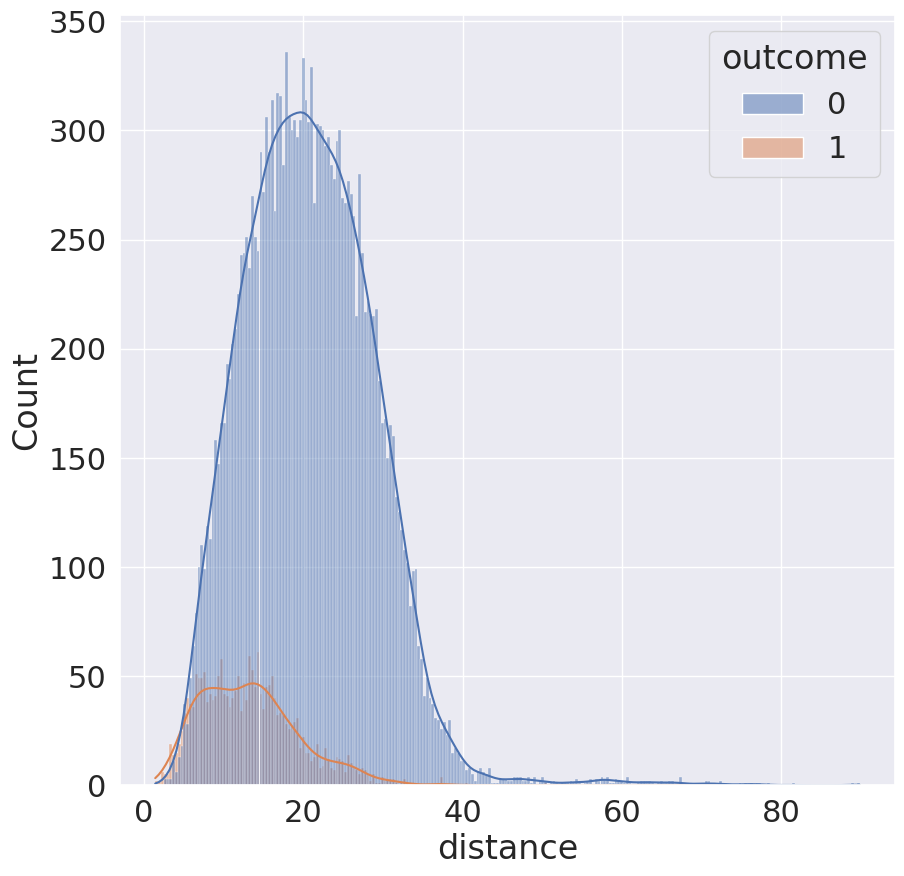

In [52]:
fig = plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.histplot(data=shots_data, x='distance' , bins=250 , kde=True, hue='outcome')

<Axes: xlabel='angle', ylabel='Count'>

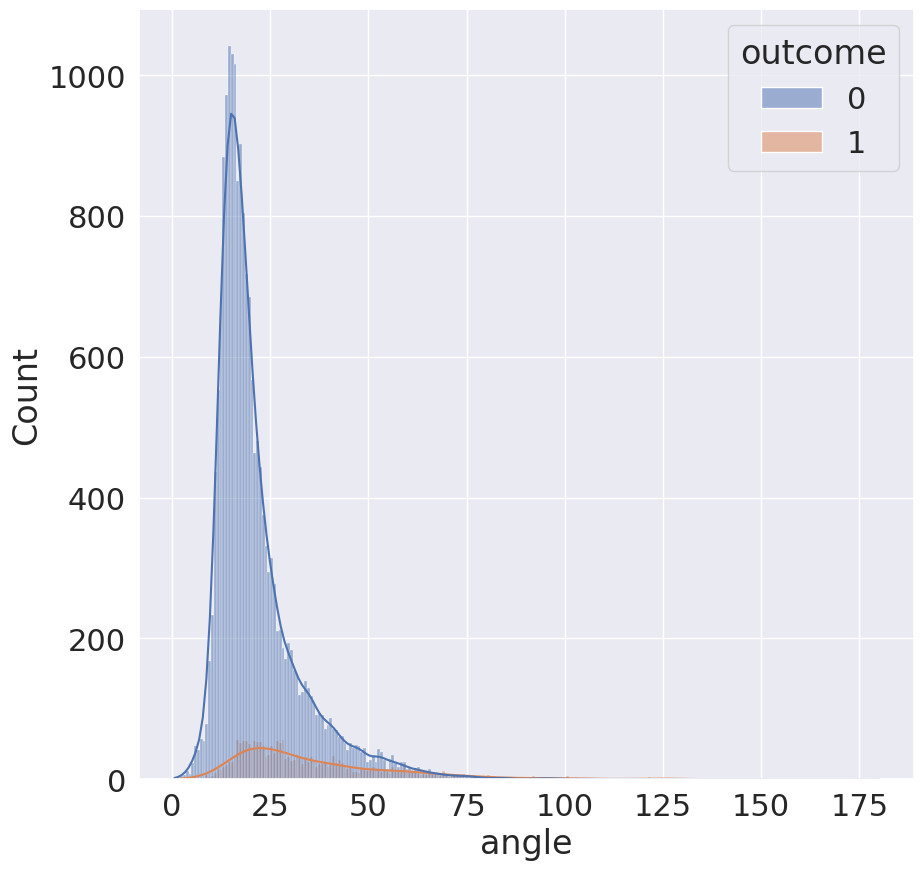

In [53]:
fig = plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.histplot(data=shots_data, x='angle' , bins=250 , kde=True, hue='outcome')

In [54]:
shots_data.to_csv('shots_data_2015_25.csv')